# AML Data Preprocessing
- Using the IBM dataset for AML: https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml
- Dataset is generated by IBM Box Generator, models transactions and illicit activities.
- Original dataset for training will be extensively large, for initial stages of thesis, using smaller dataset of 500,000 transactions.
- In the following we will:
1. explore the data
2. determine nodes and edges
3. determine node and edge attributes
4. create visualization using NetworkX, PyVis, or Graph-tool

* Attributes on ACCOUNT
    * Bank account
    * Account balance
    * BIN number
    * Number of transactions (calculated)
    * Receiving Currency
* Attributes on TRANSACTIONS
    * Payment amount
    * Payment Type
    * Payment Currency (based on “receiving currency” of outgoing bank account)
    * Time


## BASICS

### --- IMPORT LIBRARIES ---

In [143]:
! pip3 install torch numpy pandas matplotlib torch-geometric

In [144]:
import torch
import time
import random
import hashlib
import datetime
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from pandas import Timestamp
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

### --- LOAD DATASET ---

In [145]:
filename = "/Users/owhy/Documents/Datasets/HI-Small_Trans_3.csv"

In [146]:
data = pd.read_csv(filename)
data.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [147]:
print(f"---- shape ----\n - {data.shape}")

---- shape ----
 - (4999, 11)


In [148]:
n_fraudulent_trx = len(data[data["Is Laundering"]==1])
n_non_fraudulent_trx = len(data[data["Is Laundering"]==0])
print(f"Number of fraudulent transactions: {n_fraudulent_trx}")
print(f"Number of non-fraudulent transactions: {n_non_fraudulent_trx}")

Number of fraudulent transactions: 1
Number of non-fraudulent transactions: 4998


In [149]:
labels = data["Is Laundering"].to_numpy()
labels

array([0, 0, 0, ..., 0, 0, 0])

In [150]:
print("---- info ----")
data.info()

---- info ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Timestamp           4999 non-null   object 
 1   From Bank           4999 non-null   int64  
 2   Account             4999 non-null   object 
 3   To Bank             4999 non-null   int64  
 4   Account.1           4999 non-null   object 
 5   Amount Received     4999 non-null   float64
 6   Receiving Currency  4999 non-null   object 
 7   Amount Paid         4999 non-null   float64
 8   Payment Currency    4999 non-null   object 
 9   Payment Format      4999 non-null   object 
 10  Is Laundering       4999 non-null   int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 429.7+ KB


In [151]:
print("---- basic calculations ----")
data.describe()

---- basic calculations ----


,From Bank,To Bank,Amount Received,Amount Paid,Is Laundering
count,4999.000000,4999.000000,4.999000e+03,4.999000e+03,4999.000000
mean,1789.501900,4942.668534,1.359356e+06,1.359356e+06,0.000200
std,4284.999187,22743.152876,1.908775e+07,1.908775e+07,0.014144
min,1.000000,1.000000,1.000000e-02,1.000000e-02,0.000000
25%,10.000000,12.000000,2.042000e+01,2.042000e+01,0.000000
50%,795.000000,1292.000000,2.647170e+03,2.647170e+03,0.000000
75%,1601.000000,1674.000000,2.939065e+04,2.939065e+04,0.000000
max,31440.000000,250810.000000,8.295520e+08,8.295520e+08,1.000000


#### ensuring there are no null instances

In [152]:
print(data.isnull().sum())

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64


#### are transactions_received and transactions_paid the same?

In [153]:
print("Are Amount Paid entirely equal to Amount Received?\n - " + str(data["Amount Paid"].equals(data["Amount Received"])))
print("Are Currency Received entirely equal to Currency Paid?\n - " + str(data["Payment Currency"].equals(data["Receiving Currency"])))

Are Amount Paid entirely equal to Amount Received?
 - False
Are Currency Received entirely equal to Currency Paid?
 - False


#### What are the unique variables and how many are there?

In [154]:
print(sorted(data["Receiving Currency"].unique()))
print(sorted(data["Payment Currency"].unique()))
print(sorted(data["Payment Format"].unique()))
print(len(data["Account"].unique()))

['Bitcoin', 'Euro', 'US Dollar']
['Bitcoin', 'Euro', 'US Dollar']
['ACH', 'Bitcoin', 'Cash', 'Cheque', 'Credit Card', 'Reinvestment', 'Wire']
3734


## NODE MATRIX

Nodes = Bank Accounts -- bank account number
* BIN Number
* Receiving Currency

* Number of transactions (degree matrix --> calculated based on incoming and outcoming flows)

Edges = transactions -- payment amount
* Payment Type
* Payment Currency
* Date and Time

* Account Balance (before transactions)

In [155]:
data

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0
...,...,...,...,...,...,...,...,...,...,...,...
4994,2022/09/01 00:15,11318,80087D580,11318,80087D580,15.73,US Dollar,15.73,US Dollar,Reinvestment,0
4995,2022/09/01 00:02,1674,80087D1B0,1674,80087D1B0,12.19,US Dollar,12.19,US Dollar,Reinvestment,0
4996,2022/09/01 00:19,220,80087EA60,220,80087EA60,2075.73,US Dollar,2075.73,US Dollar,Reinvestment,0
4997,2022/09/01 00:19,2843,8008789D0,2843,8008789D0,604.51,US Dollar,604.51,US Dollar,Reinvestment,0


In [156]:
### merging all accounts and getting unique values

# Merge "Account" and "Account.1" columns
merged_accounts = pd.concat([data['Account'], data['Account.1']])

# Merge "From Bank" and "To Bank" columns
merged_banks = pd.concat([data['From Bank'], data['To Bank']])

# Merge "Receiving Currency" and "Payment Currency" columns
merged_currencies = pd.concat([data['Receiving Currency'], data['Payment Currency']])

# Create a new DataFrame with merged columns
merged_df = pd.DataFrame({
    'Accounts': merged_accounts,
    'Bank': merged_banks,
    'Currency': merged_currencies
})

merged_df


,Accounts,Bank,Currency
0,8000EBD30,10,US Dollar
1,8000F4580,3208,US Dollar
2,8000F4670,3209,US Dollar
3,8000F5030,12,US Dollar
4,8000F5200,10,US Dollar
...,...,...,...
4994,80087D580,11318,US Dollar
4995,80087D1B0,1674,US Dollar
4996,80087EA60,220,US Dollar
4997,8008789D0,2843,US Dollar


In [157]:
# Drop duplicates based on the "Accounts" column to ensure uniqueness
unique_accounts = merged_df.drop_duplicates(subset=['Accounts']).reset_index(drop=True)
unique_accounts

,Accounts,Bank,Currency
0,8000EBD30,10,US Dollar
1,8000F4580,3208,US Dollar
2,8000F4670,3209,US Dollar
3,8000F5030,12,US Dollar
4,8000F5200,10,US Dollar
...,...,...,...
4183,80DFA4640,120046,US Dollar
4184,8023E3CE0,2824,US Dollar
4185,80086B8D0,10,US Dollar
4186,80E1EEE10,35925,US Dollar


#### --- One-hot encoding: currency ---

In [158]:
# Convert non-numeric columns
positions = unique_accounts["Currency"].str.split(",", expand=True) # creating new columns by splitting receiving currency --> all are added
unique_accounts["first_position"] = positions[0] # first currency in each row is extracted --> actual currency used and that we want as TRUE
# One-hot encoding
node_features = pd.concat([unique_accounts, pd.get_dummies(unique_accounts["first_position"],dtype='int')], axis=1, join='inner') # effectively adds actual currency to dummy variables/columns
node_features.drop(["Currency", "first_position"], axis=1, inplace=True) # drop the axiliary columns
node_features.head()

# TODO-DONE! conc unnique random number to the end --> maintain uniqueness
# TODO-DONE! node --> feature --> feature2 --> node2 | problem with uniqueness of node embeddings --> add unique value to identify the node feature vector
# TODO-DONE! create random identity vector for each ACCOUNT + add Account and From Bank as separate properties of the node
# TODO-DONE! ultimately normalize From bank
# TODO-DONE! feature matrix -- > receiving currency n-hot encoding (0 and 1) + encoding of From Bank and Account (word2vec)
# TODO add edge features --> look into EDGE LABELED GRAPHS where all nodes and edges have labels
# TODO create init for loading graph --> initial step


,Accounts,Bank,Bitcoin,Euro,US Dollar
0,8000EBD30,10,0,0,1
1,8000F4580,3208,0,0,1
2,8000F4670,3209,0,0,1
3,8000F5030,12,0,0,1
4,8000F5200,10,0,0,1


#### --- Normalization and Vectorization ---

In [159]:
# Normalize 'From Bank' & 'Account'
def normalize(table, new_min=0, new_max=10):
    if len(table.columns) == 1:
        normalized_df = ((table - table.min()) / (table.max() - table.min())) * (new_max - new_min) + new_min
        return normalized_df
    else:
        normalized_df = pd.DataFrame()
        id = 0
        for column in table.columns:
            col_data = table[column]
            if id == 0:
                normalized_df[f'col_{id}'] = ((col_data - col_data.min()) / (col_data.max() - col_data.min())) * (new_max - new_min) + new_min
            else:
                normalized_column = ((col_data - col_data.min()) / (col_data.max() - col_data.min())) * (new_max - new_min) + new_min
                normalized_df[f'col_{id}'] = normalized_column
            id += 1
        # print(normalized_df)
        return normalized_df

def hashing_vectorization(strings, vector_size=9):
    vectors = []
    for string in strings:
        # Hash the string using hash()
        hashed_values = hash(string) % (10 ** vector_size)  # Ensures unique representations within the specified range

        # Convert hashed values to a fixed-size vector
        vector = [int(digit) for digit in str(hashed_values)]

        # Ensure vector has the desired size by zero-padding or truncating
        if len(vector) < vector_size:
            vector = [0] * (vector_size - len(vector)) + vector
        elif len(vector) > vector_size:
            vector = vector[:vector_size]

        vectors.append(vector)

    return vectors

In [160]:
from_bank_col = node_features.pop('Bank')
account_col = node_features.pop('Accounts')

In [161]:
# node labels for later use

node_labels = pd.DataFrame(account_col)
node_labels

,Accounts
0,8000EBD30
1,8000F4580
2,8000F4670
3,8000F5030
4,8000F5200
...,...
4183,80DFA4640
4184,8023E3CE0
4185,80086B8D0
4186,80E1EEE10


In [162]:
# TODO add vectors as individuals columns in new dataframe

df = pd.DataFrame(account_col, columns=['Accounts'])
df.reset_index(drop=True, inplace=True) # Ensure the DataFrame has the same number of rows as the original series
vectors = hashing_vectorization(df['Accounts'], vector_size=9)

# Convert vectors into DataFrame
vectors_df = pd.DataFrame(vectors, columns=[f'col_{i}' for i in range(len(vectors[0]))])
result_df = pd.concat([df, vectors_df], axis=1)

In [163]:
accounts_df = result_df.drop(columns=["Accounts"])

In [164]:
from_bank_col

0           10
1         3208
2         3209
3           12
4           10
         ...  
4183    120046
4184      2824
4185        10
4186     35925
4187      2843
Name: Bank, Length: 4188, dtype: int64

In [165]:
from_bank_binary = [bin(x).split("b")[1] for x in from_bank_col]
# vectors_df = pd.DataFrame(vectors, columns=[f'col_{i}' for i in range(len(vectors[0]))])

res = max(from_bank_binary, key=len)
print("Longest String is  : ", res)
len(res)

from_bank_binary

Longest String is  :  110011100001101010


['1010',
 '110010001000',
 '110010001001',
 '1100',
 '1010',
 '1',
 '1',
 '1',
 '1100',
 '1',
 '1',
 '1',
 '1',
 '1010',
 '1100',
 '1',
 '1010',
 '10110001100',
 '11010000001',
 '11010000001',
 '10110001100',
 '1010',
 '1100',
 '1010',
 '1110001100',
 '10110001100',
 '11010011000',
 '1',
 '1010',
 '111100110010101',
 '1010',
 '10110001100',
 '10100001100',
 '11010001010',
 '101010001101011',
 '10101110010101',
 '1010',
 '10110000100000',
 '10110011010010',
 '11001000001',
 '10110000011',
 '10110111011',
 '10011011001',
 '10110001100',
 '10110001100',
 '11010001010',
 '10000101100',
 '10110000011',
 '10110110001',
 '10110000110110',
 '1',
 '1',
 '10110111011',
 '1100',
 '11010010110',
 '10000010111',
 '101111101011',
 '11010000001',
 '10110000100000',
 '101110100100010',
 '10111010000000',
 '11010000001111',
 '11011100',
 '1010111101',
 '1010',
 '101110101111',
 '101100011101',
 '10011011100',
 '11010010110',
 '10000101100',
 '101110100011001',
 '10111010000000',
 '101001100001010',
 '1

In [166]:
def make_binary_fixed_length(binary_lists, res):
    new_binary_list = []
    for x in binary_lists:
        # print(x)
        if len(x) < len(res):
            num_zeros = len(res) - len(x)
            x = [0] * num_zeros + x
            # print(x)
            new_binary_list.append(x)
        else:
            new_binary_list.append(x)
    return new_binary_list

In [167]:
binary_lists = [[int(bit) for bit in binary] for binary in from_bank_binary]
binary_lists = make_binary_fixed_length(binary_lists, res)
binary_lists

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

In [168]:
# Convert vectors into DataFrame
bin_vectors_df = pd.DataFrame(binary_lists, columns=[f'bin_{i}' for i in range(len(binary_lists[0]))])
bin_vectors_df

,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10,bin_11,bin_12,bin_13,bin_14,bin_15,bin_16,bin_17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4183,0,1,1,1,0,1,0,1,0,0,1,1,1,0,1,1,1,0
4184,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0
4185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4186,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,1


In [169]:
# TODO normalize vector values to avoid big numbers

from_bank_df = pd.DataFrame(from_bank_col)
accounts_df = pd.DataFrame(accounts_df)

# from_bank_df_norm = normalize(from_bank_df,0,1) # TODO do not normalize at this point --> create BINARY representation
accounts_df_norm = normalize(accounts_df,0,1)

accounts_df_norm

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8
0,0.111111,0.444444,0.333333,0.555556,0.222222,0.333333,0.777778,0.666667,0.555556
1,1.000000,0.888889,0.333333,1.000000,1.000000,0.555556,0.222222,0.888889,0.000000
2,0.555556,0.444444,0.555556,0.555556,0.000000,0.777778,0.111111,0.111111,0.666667
3,0.555556,0.222222,0.555556,0.888889,0.444444,1.000000,0.555556,0.444444,0.777778
4,0.555556,1.000000,0.333333,0.222222,1.000000,1.000000,0.666667,0.777778,0.333333
...,...,...,...,...,...,...,...,...,...
4183,0.111111,0.666667,0.333333,0.333333,1.000000,0.555556,0.000000,0.888889,0.777778
4184,1.000000,1.000000,1.000000,0.666667,1.000000,0.777778,0.333333,0.222222,0.222222
4185,0.666667,0.111111,0.444444,0.555556,0.000000,0.333333,0.444444,0.666667,0.000000
4186,0.555556,0.777778,0.666667,1.000000,0.222222,0.777778,0.222222,1.000000,0.444444


In [170]:
node_features.reset_index(drop=True, inplace=True) # Ensure the DataFrame has the same number of rows as the original series
accounts_df_norm.reset_index(drop=True, inplace=True) # Ensure the DataFrame has the same number of rows as the original series

node_features = pd.concat([node_features, accounts_df_norm], axis=1)
node_features = pd.concat([node_features, bin_vectors_df], axis=1)
node_features

,Bitcoin,Euro,US Dollar,col_0,col_1,col_2,col_3,col_4,col_5,col_6,...,bin_8,bin_9,bin_10,bin_11,bin_12,bin_13,bin_14,bin_15,bin_16,bin_17
0,0,0,1,0.111111,0.444444,0.333333,0.555556,0.222222,0.333333,0.777778,...,0,0,0,0,0,0,1,0,1,0
1,0,0,1,1.000000,0.888889,0.333333,1.000000,1.000000,0.555556,0.222222,...,0,0,1,0,0,0,1,0,0,0
2,0,0,1,0.555556,0.444444,0.555556,0.555556,0.000000,0.777778,0.111111,...,0,0,1,0,0,0,1,0,0,1
3,0,0,1,0.555556,0.222222,0.555556,0.888889,0.444444,1.000000,0.555556,...,0,0,0,0,0,0,1,1,0,0
4,0,0,1,0.555556,1.000000,0.333333,0.222222,1.000000,1.000000,0.666667,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4183,0,0,1,0.111111,0.666667,0.333333,0.333333,1.000000,0.555556,0.000000,...,0,0,1,1,1,0,1,1,1,0
4184,0,0,1,1.000000,1.000000,1.000000,0.666667,1.000000,0.777778,0.333333,...,1,1,0,0,0,0,1,0,0,0
4185,0,0,1,0.666667,0.111111,0.444444,0.555556,0.000000,0.333333,0.444444,...,0,0,0,0,0,0,1,0,1,0
4186,0,0,1,0.555556,0.777778,0.666667,1.000000,0.222222,0.777778,0.222222,...,0,0,0,1,0,1,0,1,0,1


#### --- Account: Unique Identifier ---

In [171]:
# TODO add unique random identified

unique_ids_set = set()

while len(unique_ids_set) < len(node_features): # uniqueness kept
    unique_ids_set.add(random.random())

unique_ids = list(unique_ids_set)

node_features.insert(0, "Unique ID", unique_ids)

node_features

,Unique ID,Bitcoin,Euro,US Dollar,col_0,col_1,col_2,col_3,col_4,col_5,...,bin_8,bin_9,bin_10,bin_11,bin_12,bin_13,bin_14,bin_15,bin_16,bin_17
0,0.643970,0,0,1,0.111111,0.444444,0.333333,0.555556,0.222222,0.333333,...,0,0,0,0,0,0,1,0,1,0
1,0.846079,0,0,1,1.000000,0.888889,0.333333,1.000000,1.000000,0.555556,...,0,0,1,0,0,0,1,0,0,0
2,0.526052,0,0,1,0.555556,0.444444,0.555556,0.555556,0.000000,0.777778,...,0,0,1,0,0,0,1,0,0,1
3,0.877478,0,0,1,0.555556,0.222222,0.555556,0.888889,0.444444,1.000000,...,0,0,0,0,0,0,1,1,0,0
4,0.705842,0,0,1,0.555556,1.000000,0.333333,0.222222,1.000000,1.000000,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4183,0.909296,0,0,1,0.111111,0.666667,0.333333,0.333333,1.000000,0.555556,...,0,0,1,1,1,0,1,1,1,0
4184,0.207871,0,0,1,1.000000,1.000000,1.000000,0.666667,1.000000,0.777778,...,1,1,0,0,0,0,1,0,0,0
4185,0.119818,0,0,1,0.666667,0.111111,0.444444,0.555556,0.000000,0.333333,...,0,0,0,0,0,0,1,0,1,0
4186,0.753333,0,0,1,0.555556,0.777778,0.666667,1.000000,0.222222,0.777778,...,0,0,0,1,0,1,0,1,0,1


#### --- X = Node Feature Matrix ---

In [172]:
# TODO nodes should be bank accounts and not transactions. Bank accounts have unique receiving currencies and "bank BINs"
x = node_features.to_numpy()
x.shape # [num_nodes x num_features]


(4188, 31)

## EDGE MATRIX

In [173]:
# TODO add edge features --> look into EDGE LABELED GRAPHS where all nodes and edges have labels
# TODO create init for loading graph --> initial step
# TODO add 2 levels of depth --> will be interconnected, no need to do this step

### --- Finding Links: Mapping ---

In [174]:
links = [{'source': source, 'destination': destination} for source, destination in zip(data['Account'], data['Account.1'])]
links

[{'source': '8000EBD30', 'destination': '8000EBD30'},
 {'source': '8000F4580', 'destination': '8000F5340'},
 {'source': '8000F4670', 'destination': '8000F4670'},
 {'source': '8000F5030', 'destination': '8000F5030'},
 {'source': '8000F5200', 'destination': '8000F5200'},
 {'source': '8000F5AD0', 'destination': '8000F5AD0'},
 {'source': '8000EBAC0', 'destination': '8000EBAC0'},
 {'source': '8000EC1E0', 'destination': '8000EC1E0'},
 {'source': '8000EC280', 'destination': '8017BF800'},
 {'source': '8000EDEC0', 'destination': '80AEF5310'},
 {'source': '8000F4510', 'destination': '8011305D0'},
 {'source': '8000F47F0', 'destination': '8000F47F0'},
 {'source': '8000F4FE0', 'destination': '812ED62E0'},
 {'source': '80012FD90', 'destination': '812ED6380'},
 {'source': '80012FE00', 'destination': '805B34210'},
 {'source': '80012FE50', 'destination': '80012FE50'},
 {'source': '80012FEA0', 'destination': '80012FEA0'},
 {'source': '8005DFEB0', 'destination': '8005DFEB0'},
 {'source': '8005E18F0', 'de

### --- Edge Features ---

In [175]:
# TODO add edge features --> create matrix like those for nodes

edges_df = data[["Timestamp", "Amount Paid", "Payment Currency", "Payment Format"]]
edges_df

,Timestamp,Amount Paid,Payment Currency,Payment Format
0,2022/09/01 00:20,3697.34,US Dollar,Reinvestment
1,2022/09/01 00:20,0.01,US Dollar,Cheque
2,2022/09/01 00:00,14675.57,US Dollar,Reinvestment
3,2022/09/01 00:02,2806.97,US Dollar,Reinvestment
4,2022/09/01 00:06,36682.97,US Dollar,Reinvestment
...,...,...,...,...
4994,2022/09/01 00:15,15.73,US Dollar,Reinvestment
4995,2022/09/01 00:02,12.19,US Dollar,Reinvestment
4996,2022/09/01 00:19,2075.73,US Dollar,Reinvestment
4997,2022/09/01 00:19,604.51,US Dollar,Reinvestment


#### --- Payment Encoding ---

In [176]:
edges_amount = edges_df["Amount Paid"].astype(str)
edges_amount = list(edges_amount)

In [177]:
def count_unused_decimals(number):
    # Convert number to string to iterate through digits
    num_str = str(number)
    count = 0

    # Iterate through digits from the end
    for digit in reversed(num_str):
        # If the digit is '0', increment count
        if digit == '0':
            count += 1
        # If non-zero digit encountered, break the loop
        else:
            break

    # Remove trailing zeroes from the number
    num_str = num_str.rstrip('0')

    return num_str, count

In [178]:
maximum = str(max(edges_df["Amount Paid"]))
max_len = len(maximum.split(".")[0])

minimum = min(edges_df["Amount Paid"])
minimum = format(minimum, 'f')
min_len = len(str(minimum.split('.')[1]))

new_min, count = count_unused_decimals(minimum)
min_len = min_len - count

number_columns = max_len + min_len
number_columns

11

In [179]:
def split_into_vectors(table):
    lists = []
    for binary in table:
        binary = float(binary)
        binary = str(format(binary, 'f'))
        decimal_repr = []
        for bit in binary:
            if '.' not in bit:
                decimal_repr.append(str(int(bit)))
            else:
                decimal_repr.append(bit)
        lists.append(decimal_repr)
    return lists

In [180]:
def encode_payment_amount(df_col, max_len, min_len):
    new_payment_list = []
    for x in df_col:
        # print(x)
        index_of_decimal = x.index('.')
        positive_decimals = index_of_decimal
        negative_decimals = len(x) - (index_of_decimal+1)
        if positive_decimals < max_len:
            num_zeros = max_len - positive_decimals
            x = ['0'] * num_zeros + x
            # print(x)
            new_payment_list.append(x)
        elif negative_decimals < min_len:
            num_zeros = max_len - negative_decimals
            x = ['0'] * num_zeros + x
            # print(x)
            new_payment_list.append(x)
        else:
            new_payment_list.append(x)
        x.remove('.')
    return new_payment_list

In [181]:
edges_amount

['3697.34',
 '0.01',
 '14675.57',
 '2806.97',
 '36682.97',
 '6162.44',
 '14.26',
 '11.86',
 '7.66',
 '383.71',
 '9.82',
 '9.38',
 '4.01',
 '106.7',
 '0.54',
 '3944232.29',
 '10020.68',
 '897.37',
 '157.57',
 '52.75',
 '8163.85',
 '5.74',
 '46.86',
 '9.89',
 '86.3',
 '3.16',
 '780457.62',
 '748.62',
 '1210984.0',
 '38386097.0',
 '956.43',
 '43.44',
 '159271.0',
 '3.62',
 '192.83',
 '4295104.54',
 '3203.2',
 '192154.42',
 '152631.0',
 '5069.19',
 '29382.0',
 '7.64',
 '16.03',
 '25.34',
 '146.97',
 '16.9',
 '87.71',
 '17.57',
 '19605.49',
 '424245.0',
 '2995.0',
 '527190.0',
 '15018.93',
 '17.29',
 '6.88',
 '406.38',
 '9.57',
 '42.18',
 '78061.55',
 '8468.0',
 '13818883.0',
 '9814809.87',
 '2782.0',
 '4.62',
 '44.54',
 '77.15',
 '6.28',
 '130.1',
 '11.77',
 '5.87',
 '756221.89',
 '24068.17',
 '106953.0',
 '25397.0',
 '1282.15',
 '489.99',
 '11.68',
 '149.35',
 '97.86',
 '17.38',
 '51.44',
 '46.3',
 '6.11',
 '3231020.27',
 '64631.85',
 '278.34',
 '25.23',
 '48609.72',
 '1445.91',
 '62787.0

In [182]:
a = split_into_vectors(edges_amount) # INEFFICIENT !!!! # INEFFICIENT !!!!# INEFFICIENT !!!!# INEFFICIENT !!!!# INEFFICIENT !!!!

In [183]:
new_payment_list = encode_payment_amount(a, max_len, min_len) # INEFFICIENT !!!! # INEFFICIENT !!!!# INEFFICIENT !!!!# INEFFICIENT !!!!# INEFFICIENT !!!!
new_payment_list = nested_list_int = [[int(item) for item in sublist] for sublist in new_payment_list]
new_payment_list

[[0, 0, 0, 0, 0, 3, 6, 9, 7, 3, 4, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 4, 6, 7, 5, 5, 7, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 2, 8, 0, 6, 9, 7, 0, 0, 0, 0],
 [0, 0, 0, 0, 3, 6, 6, 8, 2, 9, 7, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 6, 1, 6, 2, 4, 4, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 4, 2, 6, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 8, 6, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 7, 6, 6, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 3, 8, 3, 7, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 9, 8, 2, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 9, 3, 8, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 6, 7, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 4, 0, 0, 0, 0],
 [0, 0, 3, 9, 4, 4, 2, 3, 2, 2, 9, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 2, 0, 6, 8, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 8, 9, 7, 3, 7, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 5, 7, 5, 7, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 5, 2, 7, 5, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 8, 1, 6, 3, 8, 5, 0, 0,

In [184]:
# Convert vectors into DataFrame
payment_vectors_df = pd.DataFrame(new_payment_list, columns=[f'payment_{i}' for i in range(len(new_payment_list[0]))])

In [185]:
edges_features = pd.concat([edges_df, payment_vectors_df], axis=1)
edges_features.drop("Amount Paid", axis='columns')

,Timestamp,Payment Currency,Payment Format,payment_0,payment_1,payment_2,payment_3,payment_4,payment_5,payment_6,payment_7,payment_8,payment_9,payment_10,payment_11,payment_12,payment_13,payment_14
0,2022/09/01 00:20,US Dollar,Reinvestment,0,0,0,0,0,3,6,9,7,3,4,0,0,0,0
1,2022/09/01 00:20,US Dollar,Cheque,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2022/09/01 00:00,US Dollar,Reinvestment,0,0,0,0,1,4,6,7,5,5,7,0,0,0,0
3,2022/09/01 00:02,US Dollar,Reinvestment,0,0,0,0,0,2,8,0,6,9,7,0,0,0,0
4,2022/09/01 00:06,US Dollar,Reinvestment,0,0,0,0,3,6,6,8,2,9,7,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,2022/09/01 00:15,US Dollar,Reinvestment,0,0,0,0,0,0,0,1,5,7,3,0,0,0,0
4995,2022/09/01 00:02,US Dollar,Reinvestment,0,0,0,0,0,0,0,1,2,1,9,0,0,0,0
4996,2022/09/01 00:19,US Dollar,Reinvestment,0,0,0,0,0,2,0,7,5,7,3,0,0,0,0
4997,2022/09/01 00:19,US Dollar,Reinvestment,0,0,0,0,0,0,6,0,4,5,1,0,0,0,0


#### --- One-hot encoding: currency ---

In [186]:
# TODO convert Currency into one-hot encoding

positions = edges_features["Payment Currency"].str.split(",", expand=True) # creating new columns by splitting receiving currency --> all are added
edges_features["first_position"] = positions[0] # first currency in each row is extracted --> actual currency used and that we want as TRUE
# One-hot encoding
edges_features = pd.concat([edges_features, pd.get_dummies(edges_features["first_position"],dtype='int')], axis=1, join='inner') # effectively adds actual currency to dummy variables/columns
edges_features.drop(["Amount Paid","Payment Currency", "first_position"], axis=1, inplace=True) # drop the axiliary columns
edges_features.head()

,Timestamp,Payment Format,payment_0,payment_1,payment_2,payment_3,payment_4,payment_5,payment_6,payment_7,payment_8,payment_9,payment_10,payment_11,payment_12,payment_13,payment_14,Bitcoin,Euro,US Dollar
0,2022/09/01 00:20,Reinvestment,0,0,0,0,0,3,6,9,7,3,4,0,0,0,0,0,0,1
1,2022/09/01 00:20,Cheque,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,2022/09/01 00:00,Reinvestment,0,0,0,0,1,4,6,7,5,5,7,0,0,0,0,0,0,1
3,2022/09/01 00:02,Reinvestment,0,0,0,0,0,2,8,0,6,9,7,0,0,0,0,0,0,1
4,2022/09/01 00:06,Reinvestment,0,0,0,0,3,6,6,8,2,9,7,0,0,0,0,0,0,1


In [187]:
# TODO convert Payment Format

positions_2 = edges_features["Payment Format"].str.split(",", expand=True)
edges_features["second_position"] = positions_2[0]
edges_features = pd.concat([edges_features, pd.get_dummies(edges_features["second_position"],dtype='int')], axis=1, join='inner') # effectively adds actual currency to dummy variables/columns
edges_features.drop(["Payment Format", "second_position"], axis=1, inplace=True) # drop the axiliary columns
edges_features.head()

,Timestamp,payment_0,payment_1,payment_2,payment_3,payment_4,payment_5,payment_6,payment_7,payment_8,...,Bitcoin,Euro,US Dollar,ACH,Bitcoin,Cash,Cheque,Credit Card,Reinvestment,Wire
0,2022/09/01 00:20,0,0,0,0,0,3,6,9,7,...,0,0,1,0,0,0,0,0,1,0
1,2022/09/01 00:20,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,2022/09/01 00:00,0,0,0,0,1,4,6,7,5,...,0,0,1,0,0,0,0,0,1,0
3,2022/09/01 00:02,0,0,0,0,0,2,8,0,6,...,0,0,1,0,0,0,0,0,1,0
4,2022/09/01 00:06,0,0,0,0,3,6,6,8,2,...,0,0,1,0,0,0,0,0,1,0


#### --- One-hot encoding: time ---

In [188]:
# TODO convert timestamps

edges_features["Timestamp"] = pd.to_datetime(edges_features['Timestamp']).astype(int) // 10**9 # does not interpret time well... circular definition for months --> sinus calculations

In [189]:
edges_features.head()

,Timestamp,payment_0,payment_1,payment_2,payment_3,payment_4,payment_5,payment_6,payment_7,payment_8,...,Bitcoin,Euro,US Dollar,ACH,Bitcoin,Cash,Cheque,Credit Card,Reinvestment,Wire
0,1661991600,0,0,0,0,0,3,6,9,7,...,0,0,1,0,0,0,0,0,1,0
1,1661991600,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,1661990400,0,0,0,0,1,4,6,7,5,...,0,0,1,0,0,0,0,0,1,0
3,1661990520,0,0,0,0,0,2,8,0,6,...,0,0,1,0,0,0,0,0,1,0
4,1661990760,0,0,0,0,3,6,6,8,2,...,0,0,1,0,0,0,0,0,1,0


### --- Y - Edge Feature Matrix

In [190]:
y = edges_features.to_numpy()
print(y[0:10])

[[1661991600          0          0          0          0          0
           3          6          9          7          3          4
           0          0          0          0          0          0
           1          0          0          0          0          0
           1          0]
 [1661991600          0          0          0          0          0
           0          0          0          0          0          1
           0          0          0          0          0          0
           1          0          0          0          1          0
           0          0]
 [1661990400          0          0          0          0          1
           4          6          7          5          5          7
           0          0          0          0          0          0
           1          0          0          0          0          0
           1          0]
 [1661990520          0          0          0          0          0
           2          8          0       

# GRAPHICAL - nx

In [191]:
graph = nx.Graph()

transaction_limit = 50 # set a limit for graph visualization

for i in range(0,transaction_limit):
    u = links[i].get("source")
    v = links[i].get("destination")
    graph.add_edge(u,v,label=edges_amount[i]) # use edge labels for edge features?

# # get all links
# for i in range(len(links)):
#     u = links[i].get("source")
#     v = links[i].get("destination")
#     graph.add_edge(u,v,label=edge_attr[i][1]) # use edge labels for edge features?

print(graph.edges(data=True))

[('8000EBD30', '8000EBD30', {'label': '3697.34'}), ('8000F4580', '8000F5340', {'label': '0.01'}), ('8000F4670', '8000F4670', {'label': '14675.57'}), ('8000F5030', '8000F5030', {'label': '2806.97'}), ('8000F5200', '8000F5200', {'label': '36682.97'}), ('8000F5AD0', '8000F5AD0', {'label': '6162.44'}), ('8000EBAC0', '8000EBAC0', {'label': '14.26'}), ('8000EC1E0', '8000EC1E0', {'label': '11.86'}), ('8000EC280', '8017BF800', {'label': '7.66'}), ('8000EDEC0', '80AEF5310', {'label': '383.71'}), ('8000F4510', '8011305D0', {'label': '9.82'}), ('8000F47F0', '8000F47F0', {'label': '9.38'}), ('8000F4FE0', '812ED62E0', {'label': '4.01'}), ('80012FD90', '812ED6380', {'label': '106.7'}), ('80012FE00', '805B34210', {'label': '0.54'}), ('80012FE50', '80012FE50', {'label': '3944232.29'}), ('80012FEA0', '80012FEA0', {'label': '10020.68'}), ('8005DFEB0', '8005DFEB0', {'label': '897.37'}), ('8005E18F0', '8005E18F0', {'label': '9.89'}), ('8005E24C0', '8005E24C0', {'label': '52.75'}), ('8005F2D30', '8005F2D30

### --- Visualization ---

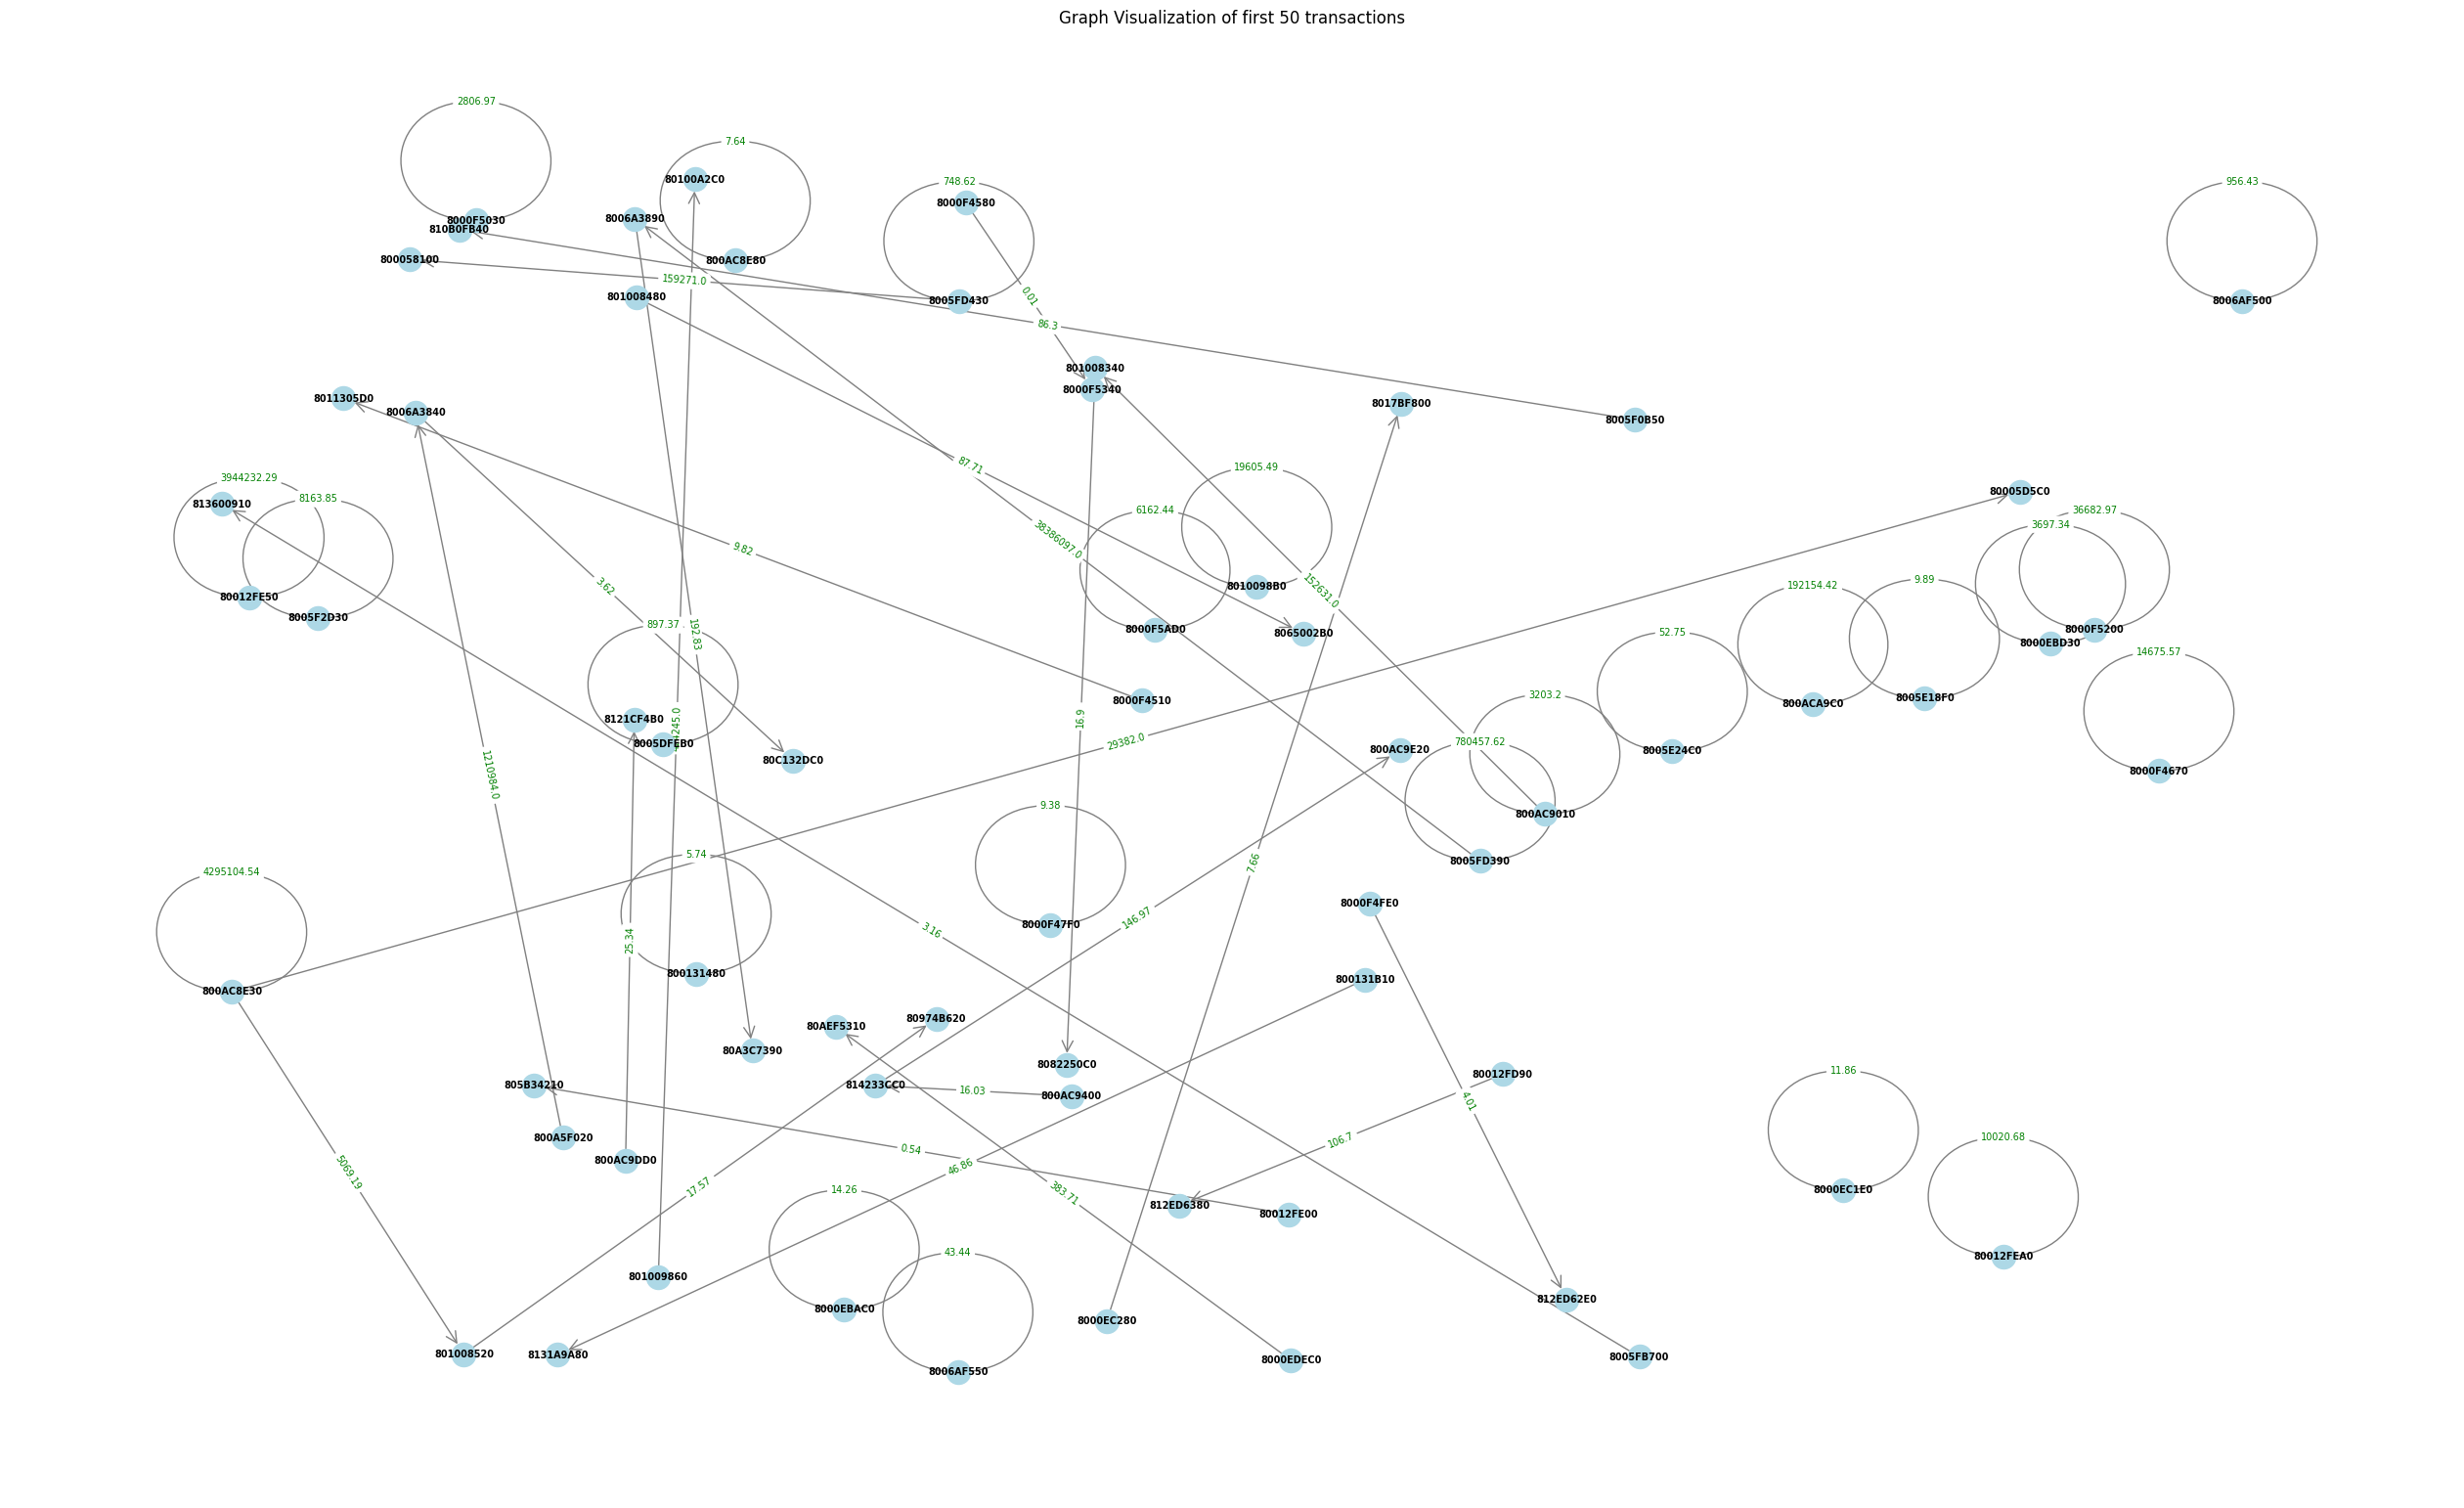

In [192]:
pos = nx.random_layout(graph) # shell, circular, spectral, spring, random,

plt.figure(figsize=(25, 15))  # Increase figure size

nx.draw(
    graph,
    pos,
    node_size=300,  # Reduce node size for better visibility
    with_labels=True,
    font_size=7,
    font_weight='bold',
    node_color='lightblue',  # Specify node color
    edge_color='gray',  # Specify edge color
    width=1,  # Adjust edge width
    arrows=True,  # Show arrows for directed edges
    arrowstyle='->',  # Specify arrow style
    arrowsize=20,  # Adjust arrow size
)

edge_labels = nx.get_edge_attributes(graph, 'label')
nx.draw_networkx_edge_labels(
    graph,
    pos,
    edge_labels=edge_labels,
    label_pos=0.5,  # Adjust label position along edges
    font_size=7,  # Adjust font size
    font_color='green',  # Specify font color
)

plt.title(f'Graph Visualization of first {transaction_limit} transactions')  # Add title to the plot
plt.axis('off')  # Hide axis
plt.show()

In [193]:
# dictionaries

degree_of_centrality = nx.degree_centrality(graph) # closeness_centrality, eigenvector_centrality, betweeness_centrality
betweenness_centrality = nx.betweenness_centrality(graph)

# TODO add statistics to a new dataframe

node_stat_features = pd.DataFrame()
node_stat_features['account'] = degree_of_centrality.keys()
node_stat_features['degree_of_centrality'] = degree_of_centrality.values()
node_stat_features['betweenness_centrality'] = betweenness_centrality.values()

node_stat_features

,account,degree_of_centrality,betweenness_centrality
0,8000EBD30,0.031746,0.0
1,8000F4580,0.015873,0.0
2,8000F5340,0.015873,0.0
3,8000F4670,0.031746,0.0
4,8000F5030,0.031746,0.0
...,...,...,...
59,8065002B0,0.015873,0.0
60,80974B620,0.015873,0.0
61,8010098B0,0.031746,0.0
62,801009860,0.015873,0.0


### --- Statistics as Features - Skip if not needed ---

In [194]:
# Add statistics df to the original df if necessary to include

# TODO format decimal point system to exclude power values.

# node_stat_features.drop('account')

# edges_features_w_stats = pd.concat([node_features, node_stat_features], axis=1)
# edges_features_w_stats

# ADJACENCY MATRIX - nx

### --- Loading full graph ---

In [252]:
# GETTING FULL GRAPH

graph_full = nx.Graph()

# get all links
for i in range(len(links)):
    u = links[i].get("source")
    v = links[i].get("destination")
    graph_full.add_edge(u,v,label=edges_amount[i]) # use edge labels for edge features?

In [253]:
print(len(edges_features))
print(len(links)) # number of transactions

4999
4999


In [254]:
links

[{'source': '8000EBD30', 'destination': '8000EBD30'},
 {'source': '8000F4580', 'destination': '8000F5340'},
 {'source': '8000F4670', 'destination': '8000F4670'},
 {'source': '8000F5030', 'destination': '8000F5030'},
 {'source': '8000F5200', 'destination': '8000F5200'},
 {'source': '8000F5AD0', 'destination': '8000F5AD0'},
 {'source': '8000EBAC0', 'destination': '8000EBAC0'},
 {'source': '8000EC1E0', 'destination': '8000EC1E0'},
 {'source': '8000EC280', 'destination': '8017BF800'},
 {'source': '8000EDEC0', 'destination': '80AEF5310'},
 {'source': '8000F4510', 'destination': '8011305D0'},
 {'source': '8000F47F0', 'destination': '8000F47F0'},
 {'source': '8000F4FE0', 'destination': '812ED62E0'},
 {'source': '80012FD90', 'destination': '812ED6380'},
 {'source': '80012FE00', 'destination': '805B34210'},
 {'source': '80012FE50', 'destination': '80012FE50'},
 {'source': '80012FEA0', 'destination': '80012FEA0'},
 {'source': '8005DFEB0', 'destination': '8005DFEB0'},
 {'source': '8005E18F0', 'de

In [255]:
print(len(unique_accounts))
print(graph_full.__len__()) # number of nodes in the graph

4188
4188


In [264]:
adjacency_matrix = nx.adjacency_matrix(graph_full)
adjacency_matrix

<4188x4188 sparse array of type '<class 'numpy.int64'>'
	with 4874 stored elements in Compressed Sparse Row format>

In [265]:
adjacency_matrix = adjacency_matrix.todense()
adjacency_matrix

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [257]:
print(adjacency_matrix) # index of nodes
print(len(adjacency_matrix))

[[1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
4188


In [258]:
print(type(adjacency_matrix))

<class 'numpy.ndarray'>


In [259]:
adjacency_matrix = torch.from_numpy(adjacency_matrix).to(torch.float)
print(adjacency_matrix.size())

torch.Size([4188, 4188])


In [260]:
num_ones = (adjacency_matrix == 1).sum().item()
print("Number of ones:", num_ones)

Number of ones: 4874


In [245]:
edge_index = torch.tensor(np.array(adjacency_matrix.nonzero()), dtype=torch.long)
edge_index

tensor([[   0,    1,    2,  ..., 4185, 4186, 4187],
        [   0,    2,    1,  ..., 4185, 4186, 4187]])

In [246]:
print(edge_index.size())

torch.Size([2, 4874])


In [205]:
node_features = node_features.to_numpy()
edges_features = edges_features.to_numpy()

In [206]:
print(node_features)
print(edges_features)

[[0.64396951 0.         0.         ... 0.         1.         0.        ]
 [0.84607928 0.         0.         ... 0.         0.         0.        ]
 [0.52605158 0.         0.         ... 0.         0.         1.        ]
 ...
 [0.11981758 0.         0.         ... 0.         1.         0.        ]
 [0.75333304 0.         0.         ... 1.         0.         1.        ]
 [0.87109237 0.         0.         ... 0.         1.         1.        ]]
[[1661991600          0          0 ...          0          1          0]
 [1661991600          0          0 ...          0          0          0]
 [1661990400          0          0 ...          0          1          0]
 ...
 [1661991540          0          0 ...          0          1          0]
 [1661991540          0          0 ...          0          1          0]
 [1661992140          0          0 ...          0          1          0]]


In [207]:
node_features = torch.from_numpy(node_features).to(torch.float)
edges_features = torch.from_numpy(edges_features).to(torch.float)
labels = torch.from_numpy(labels).to(torch.float)

In [209]:
print(node_features.size())
print(edges_features.size())
print(adjacency_matrix.size())
print(labels.size())

torch.Size([4188, 31])
torch.Size([4999, 26])
torch.Size([4188, 4188])
torch.Size([4999])


In [211]:
data = Data(
    x=node_features,
    edge_index=adjacency_matrix,
    edge_attr=edges_features,
    y=labels
)

In [212]:
data

Data(x=[4188, 31], edge_index=[4188, 4188], edge_attr=[4999, 26], y=[4999])

In [213]:
print(data.y.size())

torch.Size([4999])


# -------- !!! TODO !!! ----------

In [53]:
# What is node2vec?

# PLAN MONDAY
# FIX Model input Data
# TODO Create equivalent variables but flip nodes with edges

# DONE Understand architecture
# DONE Understand model input data
# TODO There are missing connections in the adjacency matrix # IDEA scrap adjacency matrix entirely if necessary?
# TODO Create model without NeighborSampler
# TODO Clean code
# TODO Send email with Update (ask about servers?)
# TODO Watch GNN Theory
# TODO Write up Introduction

# PLAN TUESDAY
# TODO Understand Math Theory
# TODO Write up methodology theory

# PLAN WEDNESDAY
# TODO Write up Literature Review

In [54]:
"""
NEXT 2 WEEKS:

1. Vectorize "BANKS" - BINs using binary encoding --> DONE!!!
2. Vectorize "Amount Paid" --> DONE!!!
3. Mapping through dictionary of all links --> No need to find individual links between accounts --> we are taking all accounts and the graph in general  --> DONE!!!
4. Graph Visualization should include labels that are actual accounts  --> DONE!!!
5. Add statistics to feature matrix X? --> if necessary --> DONE!!!
6. Apply graph on subset of 1000 transactions  --> DONE!!! --> not a problem at all, efficiency is better.
7. Create Adjacency Matrix --> can be done through networkx or through existing links --> DONE!!!
7a. Get unique nodes from both "Account" and "Account.1"  --> DONE!!!

7b. If laundering --> make node red

8. Create GNN model
8a. Create smaller graph
8b. Simple GNN, testing on dataset

9. Write introduction
10. Write literature review

"""

'\nNEXT 2 WEEKS:\n\n1. Vectorize "BANKS" - BINs using binary encoding --> DONE!!!\n2. Vectorize "Amount Paid" --> DONE!!!\n3. Mapping through dictionary of all links --> No need to find individual links between accounts --> we are taking all accounts and the graph in general  --> DONE!!!\n4. Graph Visualization should include labels that are actual accounts  --> DONE!!!\n5. Add statistics to feature matrix X? --> if necessary --> DONE!!!\n6. Apply graph on subset of 1000 transactions  --> DONE!!! --> not a problem at all, efficiency is better.\n7. Create Adjacency Matrix --> can be done through networkx or through existing links --> DONE!!!\n7a. Get unique nodes from both "Account" and "Account.1"  --> DONE!!!\n\n7b. If laundering --> make node red\n\n8. Create GNN model\n8a. Create smaller graph\n8b. Simple GNN, testing on dataset\n\n9. Write introduction\n10. Write literature review\n\n'

# GNN

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [219]:
# # Define the GCN model
# class Net(nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super(Net, self).__init__()
#         self.conv1 = GCNConv(in_channels, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, out_channels)

#     def encode(self, x, edge_index):
#         x = self.conv1(x, edge_index).relu()
#         return self.conv2(x, edge_index)

#     def decode(self, z, pos_edge_index, neg_edge_index):
#         edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
#         return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv, Linear

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, int(hidden_channels/4), heads=1, concat=False, dropout=0.6)
        self.lin = Linear(int(hidden_channels/4), out_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.lin(x)
        x = self.sigmoid(x)
        
        return x

In [220]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling, train_test_split_edges
import networkx as nx

# Define the graph
graph_full = nx.Graph()

# Add all links to the graph
for i in range(len(links)):
    u = links[i].get("source")
    v = links[i].get("destination")
    graph_full.add_edge(u, v, label=edges_amount[i])

# Convert adjacency matrix to edge_index tensor
adjacency_matrix = nx.adjacency_matrix(graph_full)
num_nodes = adjacency_matrix.shape[0]
edge_index = torch.tensor(np.array(adjacency_matrix.nonzero()), dtype=torch.long)

print(edge_index)
print(edge_index.size())

# For undirected graphs, concatenate the edge_index with its reverse
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
print(edge_index)
print(edge_index.size())

# Define node features
node_features = torch.tensor(x, dtype=torch.float)

# Create the PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index)

# Separate dataset into training and testing sets
data = train_test_split_edges(data)

# Define hyperparameters
num_epochs = 100
hidden_channels = 64
out_channels = 32
learning_rate = 0.01

# Initialize the model, optimizer, and loss function
model = Net(node_features.shape[1], hidden_channels, out_channels).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

# Define a function to train the model
def train(data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1), method='sparse')

    pos_label = torch.ones(data.train_pos_edge_index.size(1), dtype=torch.float, device=device)
    neg_label = torch.zeros(neg_edge_index.size(1), dtype=torch.float, device=device)
    edge_label = torch.cat([pos_label, neg_label], dim=0)

    out = model.decode(z, data.train_pos_edge_index, neg_edge_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()

# Define a function to evaluate the model
def test(data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
        out = model.decode(z, data.train_pos_edge_index, data.test_neg_edge_index).view(-1).sigmoid()
        return out.cpu().numpy()

train_losses = []
test_aucs = []

# Train/Test Loop with logging
best_val_auc = final_test_auc = 0
for epoch in range(1, num_epochs + 1):
    loss = train(data)
    test_auc = test(data)
    print(f'Epoch: {epoch}, Loss: {loss}, Test AUC: {test_auc}')

    # Append training loss and test AUC values to the lists
    train_losses.append(loss)
    test_aucs.append(test_auc)

    if np.any(test_auc > best_val_auc):
        best_val_auc = np.max(test_auc)
        final_test_auc = test_auc

# Plot training loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Compute statistics of test AUC values
mean_auc = np.mean(test_aucs)
median_auc = np.median(test_aucs)
std_auc = np.std(test_aucs)
min_auc = np.min(test_aucs)
max_auc = np.max(test_aucs)

# Print the statistics
print(f"Mean Test AUC: {mean_auc:.4f}")
print(f"Median Test AUC: {median_auc:.4f}")
print(f"Standard Deviation of Test AUC: {std_auc:.4f}")
print(f"Minimum Test AUC: {min_auc:.4f}")
print(f"Maximum Test AUC: {max_auc:.4f}")

tensor([[   0,    1,    2,  ..., 4185, 4186, 4187],
        [   0,    2,    1,  ..., 4185, 4186, 4187]])
torch.Size([2, 4874])
tensor([[   0,    1,    2,  ..., 4185, 4186, 4187],
        [   0,    2,    1,  ..., 4185, 4186, 4187]])
torch.Size([2, 9748])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


TypeError: Net.__init__() missing 1 required positional argument: 'heads'

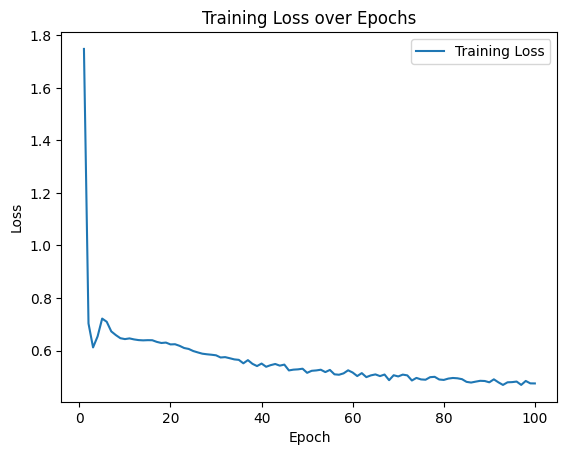

Mean Test AUC: 0.7489
Median Test AUC: 0.7628
Standard Deviation of Test AUC: 0.1446
Minimum Test AUC: 0.0347
Maximum Test AUC: 0.9998


In [64]:
# Plot training loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Compute statistics of test AUC values
mean_auc = np.mean(test_aucs)
median_auc = np.median(test_aucs)
std_auc = np.std(test_aucs)
min_auc = np.min(test_aucs)
max_auc = np.max(test_aucs)

# Print the statistics
print(f"Mean Test AUC: {mean_auc:.4f}")
print(f"Median Test AUC: {median_auc:.4f}")
print(f"Standard Deviation of Test AUC: {std_auc:.4f}")
print(f"Minimum Test AUC: {min_auc:.4f}")
print(f"Maximum Test AUC: {max_auc:.4f}")


In [65]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling, train_test_split_edges
import networkx as nx

# Load your DataFrame and extract required columns (e.g., node features and labels)
# Assuming node_features and labels are numpy arrays

# Define the graph
graph_full = nx.Graph()

# Add all links to the graph
for i in range(len(links)):
    u = links[i].get("source")
    v = links[i].get("destination")
    graph_full.add_edge(u, v, label=edges_amount[i])

# Convert adjacency matrix to edge_index tensor
adjacency_matrix = nx.adjacency_matrix(graph_full)
num_nodes = adjacency_matrix.shape[0]
edge_index = torch.tensor(np.array(adjacency_matrix.nonzero()), dtype=torch.long)

# For undirected graphs, concatenate the edge_index with its reverse
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

# Define node features and labels
node_features = torch.tensor(x, dtype=torch.float)
labels = torch.tensor(labels, dtype=torch.float)  # Assuming y contains labels for each transaction

# Create the PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, y=labels)

# Separate dataset into training and testing sets
data = train_test_split_edges(data)

# Define hyperparameters
num_epochs = 100
hidden_channels = 64
out_channels = 32
learning_rate = 0.01

# Define the GCN model
class Net(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Net, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.fc(x)
        return x

# Initialize the model, optimizer, and loss function
model = Net(node_features.shape[1], hidden_channels, out_channels).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

# Modify train function to use all nodes in the graph for target labels
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x.to(device), data.train_pos_edge_index.to(device))
    # Flatten the output and target tensors
    out_flat = out.view(-1)
    target = data.y.view(-1)
    loss = criterion(out_flat, target.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

# Modify test function to predict labels for all nodes in the graph
def test(data):
    model.eval()
    with torch.no_grad():
        out = model(data.x.to(device), data.train_pos_edge_index.to(device))
        return out.cpu().numpy()

# Train/Test Loop with logging
best_val_auc = final_test_auc = 0
for epoch in range(1, num_epochs + 1):
    loss = train(data)
    test_auc = test(data)
    print(f'Epoch: {epoch}, Loss: {loss}, Test AUC: {test_auc}')


/var/folders/mg/p4w0pb9d2m3f66bt6mgxyfdm0000gn/T/ipykernel_2548/3661489454.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float)  # Assuming y contains labels for each transaction


ValueError: Target size (torch.Size([4999])) must be the same as input size (torch.Size([4188]))

In [66]:
# Test all instances
predictions_all, probabilities_all = test(data)

# Count TRUE and FALSE predictions
num_true = np.sum(predictions_all)
num_false = len(predictions_all) - num_true
print(f"Number of TRUE predictions: {num_true}")
print(f"Number of FALSE predictions: {num_false}")

# Inspect specific instances (e.g., indices 0, 1, 2)
indices_to_inspect = [0, 1, 2]
predictions_specific, probabilities_specific = test(data, indices=indices_to_inspect)
print("Predictions for specific instances:", predictions_specific)
print("Probabilities for specific instances:", probabilities_specific)

ValueError: too many values to unpack (expected 2)

In [ ]:
import torch
from model import GAT
from dataset import AMLtoGraph
import torch_geometric.transforms as T
from torch_geometric.loader import NeighborLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = AMLtoGraph('/path/to/AntiMoneyLaunderingDetectionWithGNN/data')
data = dataset[0]
epoch = 100

model = GAT(in_channels=data.num_features, hidden_channels=16, out_channels=1, heads=8)
model = model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

split = T.RandomNodeSplit(split='train_rest', num_val=0.1, num_test=0)
data = split(data)

train_loader = NeighborLoader(
    data,
    num_neighbors=[30] * 2,
    batch_size=256,
    input_nodes=data.train_mask,
)

test_loader = NeighborLoader(
    data,
    num_neighbors=[30] * 2,
    batch_size=256,
    input_nodes=data.val_mask,
)

for i in range(epoch):
    total_loss = 0
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        data.to(device)
        pred = model(data.x, data.edge_index, data.edge_attr)
        ground_truth = data.y
        loss = criterion(pred, ground_truth.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
    if epoch%10 == 0:
        print(f"Epoch: {i:03d}, Loss: {total_loss:.4f}")
        model.eval()
        acc = 0
        total = 0
        with torch.no_grad():
            for test_data in test_loader:
                test_data.to(device)
                pred = model(test_data.x, test_data.edge_index, test_data.edge_attr)
                ground_truth = test_data.y
                correct = (pred == ground_truth.unsqueeze(1)).sum().item()
                total += len(ground_truth)
                acc += correct
            acc = acc/total
            print('accuracy:', acc)

In [ ]:
# node embedding: ADJACENCY MATRIX * NODE FEATURES

In [63]:
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the GNN architecture
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.gc1 = GraphConvolution(input_dim, hidden_dim)
        self.gc2 = GraphConvolution(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, adj):
        x = self.relu(self.gc1(x, adj))
        x = self.relu(self.gc2(x, adj))
        x = self.fc(x)
        return x

class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GraphConvolution, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        out = torch.matmul(adj, x)  # Aggregate neighbor information
        out = self.linear(out)
        return out


In [66]:
# Prepare data
# Assuming x is node features, y is edge features, and adjacency_matrix is the adjacency matrix

# Define some constants
num_nodes = x.shape[0]
input_dim = x.shape[1]
output_dim = 1  # Binary classification: fraud or not
hidden_dim = 64

# Convert numpy arrays to PyTorch tensors
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)
adjacency_matrix = torch.FloatTensor(adjacency_matrix) ### INEFFICIENT !!!

# Split data into train and test sets
num_train_samples = 4000
train_indices = np.random.choice(num_nodes, num_train_samples, replace=False)
test_indices = np.setdiff1d(np.arange(num_nodes), train_indices)

x_train, x_test = x[train_indices], x[test_indices]
adj_train, adj_test = adjacency_matrix[train_indices][:, train_indices], adjacency_matrix[test_indices][:, test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Create DataLoader
train_dataset = TensorDataset(x_train, adj_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize the model
model = GNN(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [67]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        x_batch, adj_batch, y_batch = batch
        output = model(x_batch, adj_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x4000 and 64x31)

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    output = model(x_test, adj_test)
    predictions = torch.sigmoid(output).round().squeeze().numpy()

# Assuming y_test contains the true labels
accuracy = np.mean(predictions == y_test.numpy())
print(f"Accuracy: {accuracy}")


## Creating Learnable Node Embeddings

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, adj_matrix, node_features):
        # Convert adjacency matrix to PyTorch tensor
        adj_matrix_tensor = torch.from_numpy(adj_matrix).float()
        # Normalize adjacency matrix
        adj_matrix_normalized = torch.matmul(adj_matrix_tensor, torch.diag(torch.pow(torch.sum(adj_matrix_tensor, dim=1), -0.5)))
        # Convert node features to PyTorch tensor
        node_features_tensor = torch.from_numpy(node_features).float()
        # Compute node embeddings
        node_embeddings = torch.matmul(adj_matrix_normalized, node_features_tensor)
        # Apply linear transformation
        output = self.linear(node_embeddings)
        # Apply ReLU activation function
        output = F.relu(output)
        return output

class GCN(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.layer1 = GCNLayer(num_features, hidden_size)
        self.layer2 = GCNLayer(hidden_size, num_classes)

    def forward(self, adj_matrix, node_features):
        h1 = self.layer1(adj_matrix, node_features)
        output = self.layer2(adj_matrix, h1)
        return output


In [ ]:

# Example usage:
num_features = 10  # Number of node features
hidden_size = 16   # Hidden layer size
num_classes = 2    # Number of output classes
adj_matrix = torch.randn(10, 10)  # Example adjacency matrix
node_features = torch.randn(10, num_features)  # Example node features

# Create GCN model
model = GCN(num_features, hidden_size, num_classes)

# Forward pass
output = model(adjacency_matrix, x)


## SIMPLE GNN MODEL EXAMPLE

In [ ]:
import torch
import torch.nn as nnd1
import torch.nn.functional as F

In [ ]:
num_features =
hidden_dim =
num_classes =
num_epochs =
features =
adj =
labels =

In [ ]:
class GCNBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNBlock, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        x = self.linear(x)
        x = torch.matmul(adj, x)
        x = F.relu(x)
        return x
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.gcn1 = GCNBlock(input_dim, hidden_dim)
        self.gcn2 = GCNBlock(hidden_dim, output_dim)

    def forward(self, x, adj):
        x = self.gcn1(x, adj)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gcn2(x, adj)
        return x
# Define the model
model = GCN(num_features, hidden_dim, num_classes)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# Train the model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(features, adj)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()